In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import scipy as sp

In [2]:
# Load the Caltech 101 dataset
ds_train, ds_info = tfds.load('caltech101', split='train', with_info=True, as_supervised=True)

# Load Image Paths
image_files = glob('/Users/giabao/tensorflow_datasets/downloads/extracted/TAR_GZ.101_ObjectCategories.tar.gz/101_ObjectCategories/*/*.jp*g')

In [4]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)

# Build Model with only the last Conv Block (Remove AvgPool and last Dense layers)
last_activation = resnet.get_layer('conv5_block3_out')
model = Model(resnet.input, last_activation.output)

# Get weights of the last layer (predictions)
final_layer = resnet.get_layer('predictions')
weights = final_layer.get_weights()[0] # Shape: (2048, 1000)

1/1 [==============================] - 0s 408ms/step


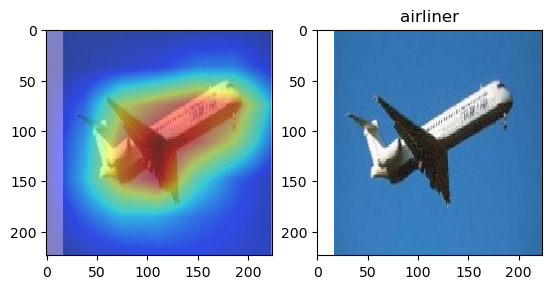

1/1 [==============================] - 0s 60ms/step


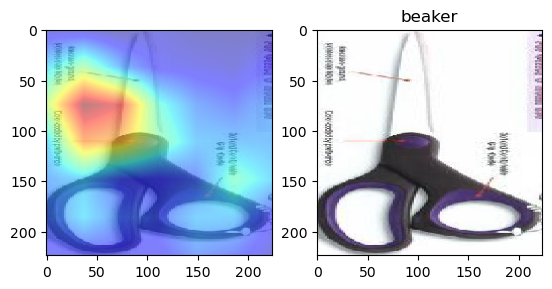

1/1 [==============================] - 0s 85ms/step


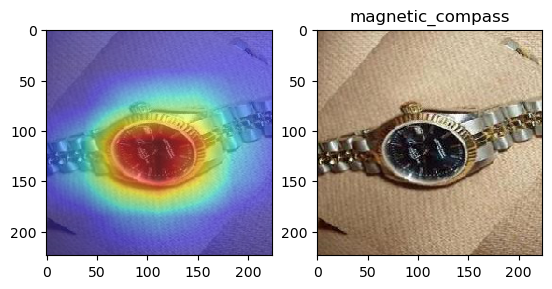

1/1 [==============================] - 0s 59ms/step


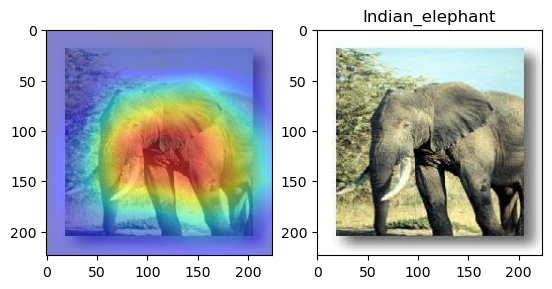

1/1 [==============================] - 0s 59ms/step


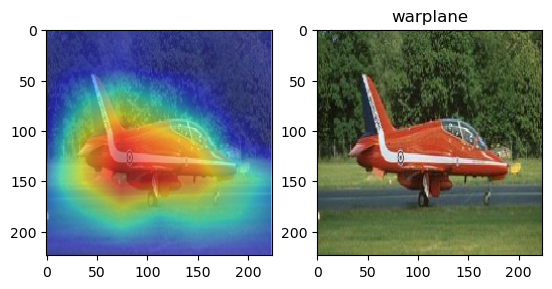

1/1 [==============================] - 0s 60ms/step


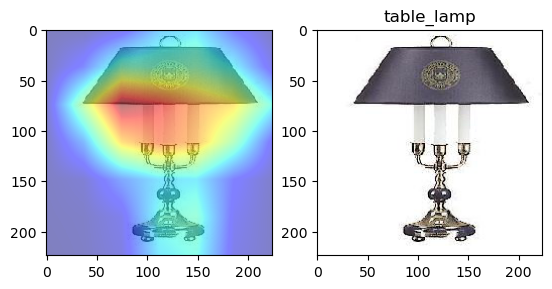

1/1 [==============================] - 0s 60ms/step


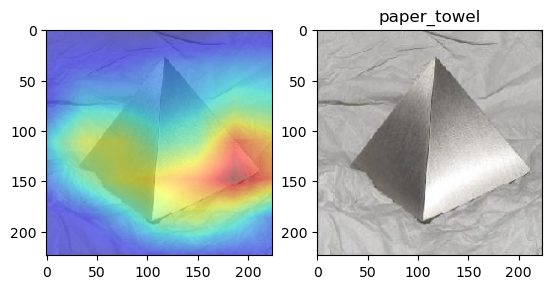

1/1 [==============================] - 0s 60ms/step


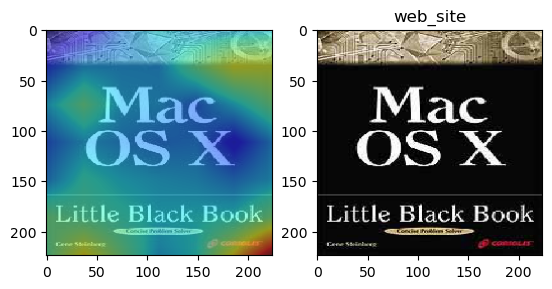

1/1 [==============================] - 0s 60ms/step


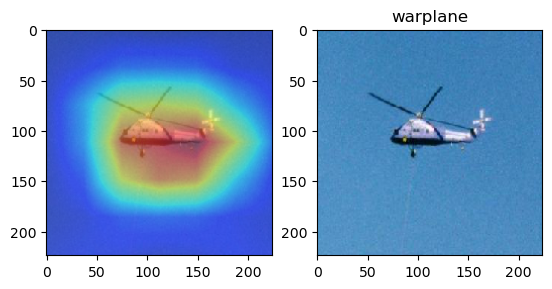

1/1 [==============================] - 0s 62ms/step


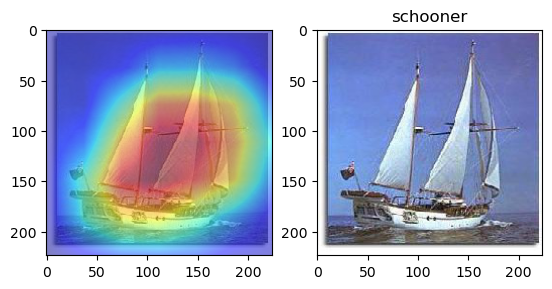

In [5]:
while True:
    # Load Image and Process it
    img = image.load_img(np.random.choice(image_files), target_size=(224, 224))
    img = np.expand_dims(img, axis = 0) 
    x = preprocess_input(img)
    
    # Outputs of the last Conv Block
    fmap = model.predict(x)[0] # 7x7x2048

    # Get classname and weights
    probs = resnet.predict(x) # Size: 1000
    classnames = decode_predictions(probs)[0]
    classname = classnames[0][1]
    pred = np.argmax(probs[0]) # Return the index of the most related class

    W = weights[:, pred] # Taking all weights of pred-th class

    # Dot product with corresponding weights
    cam = fmap.dot(W) # Shape: (7,7)
    cam = sp.ndimage.zoom(cam, (32, 32), order=1) # Upsize image back to 224x224

    # Plot Overlay 2 images
    plt.subplot(1,2,1)
    plt.imshow(img[0], alpha=0.8)
    plt.imshow(cam, alpha=0.5, cmap='jet')
    plt.subplot(1,2,2)
    plt.imshow(img[0])
    plt.title(classname)
    plt.show()

    ans = input("Continue? (Y/n): ")
    if ans and ans[0].lower() == 'n':
        break